In [105]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1 Prepare data

## 1.1 Read in data

While reading in data, a special character is detected in the column names. Solution here is to skip reading the headers and name them manually.

In [2]:
# read in data without headers, and name headers manually
data = pd.read_csv('data.txt', sep = '|', header = 0, names=['AP', 'variable', 'value'])
data.head()

,AP,variable,value
0,0,score,65
1,1,score,98
2,2,score,85
3,3,score,83
4,4,score,115


## 1.2 Transform data

Next we are going to transform the dataset into a new dataset with each column to be a variable. Before that, two things need to be done first: 
1) Check the assumption that each variable has the same number of rows in the original dataset. Besides, assume each variable has the order of observations to be the same.

2) Rename the variables according to the dictionary more intuitively: 

Rename 'i' to 'IQ_mother', which represents mother's IQ. 

Rename 'a' to 'age_birth', which represents mother's age at child's birth.

Rename 'h' to 'is_school', which represents whether mother completed high school.

Rename 'w' to 'work_category', which represents mother's different working status in child’s life.

Rename 'score' to 'IQ_child', which represents child's IQ.

In [3]:
# check the number of rows of each variable
var_list = ['i', 'a', 'h', 'w', 'score']
for var in var_list:
    print(len(data[data['variable'] == var]))

434
434
434
434
434


In [116]:
# rename & transformation
data_new = pd.DataFrame()
data_new['IQ_mother'] = data[data.variable == 'i'].reset_index()['value']
data_new['age_birth'] = data[data.variable == 'a'].reset_index()['value']
data_new['is_school'] = data[data.variable == 'h'].reset_index()['value']
data_new['work_category'] = data[data.variable == 'w'].reset_index()['value']
data_new['IQ_child'] = data[data.variable == 'score'].reset_index()['value']
data_new.head()

,IQ_mother,age_birth,is_school,work_category,IQ_child
0,'121.117528602603',27,1,4,65
1,'89.3618817100663',25,1,4,98
2,'115.443164881725',27,1,4,85
3,'99.4496394360723',25,1,3,83
4,'92.7457099982118',27,1,4,115


In [117]:
data_new.dtypes

IQ_mother        object
age_birth        object
is_school        object
work_category    object
IQ_child         object
dtype: object

The new dataset after transformation has each column to be type 'object'. According to the data dictionary, 'IQ_mother' and 'IQ_child' are floats, 'age_birth' is integer, 'work_category' 'is_school' are categorical variables. 

In [118]:
data_new['IQ_mother'] = data_new['IQ_mother'].apply(lambda x: eval(x))
data_new = data_new.astype({'IQ_mother':'float',
                            'age_birth':'int',
                            'is_school':'category',
                            'work_category':'category',
                            'IQ_child':'float'})
data_new.dtypes

IQ_mother         float64
age_birth           int32
is_school        category
work_category    category
IQ_child          float64
dtype: object

In [119]:
data_new.describe()

,IQ_mother,age_birth,IQ_child
count,434.000000,434.000000,434.000000
mean,100.000000,22.785714,86.797235
std,15.000000,2.701070,20.410688
min,71.037405,17.000000,20.000000
25%,88.660321,21.000000,74.000000
50%,97.915254,23.000000,90.000000
75%,110.272742,25.000000,102.000000
max,138.893106,29.000000,144.000000


Besides, check if there is any missing value in the dataset.

In [199]:
# calculate missing rate
for col in list(data_new.columns):
    missing_rate = sum(data_new[col].isna())/len(data_new)
    print("The missing rate of '%s' column is: %f" % (col, missing_rate))

The missing rate of 'IQ_mother' column is: 0.000000
The missing rate of 'age_birth' column is: 0.000000
The missing rate of 'is_school' column is: 0.000000
The missing rate of 'work_category' column is: 0.000000
The missing rate of 'IQ_child' column is: 0.000000


# 2 Exploratory Data Analysis

## 2.1 Histogram of response variable

First we would like to investigate the response variable, 'IQ_child'. The most intuitive way is to draw a histogram. If it's skewed, logrithm might be necessary.

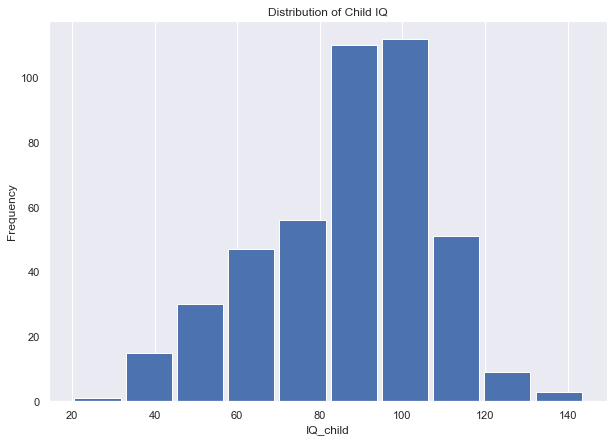

In [121]:
plt.figure(figsize=(10, 7))
plt.hist(x=data_new['IQ_child'], rwidth=0.9)
plt.title('Distribution of Child IQ')
plt.xlabel('IQ_child')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The distribution of the response variable is similar to a normal distribution. 

## 2.2 Scatterplot of IQ_mother & IQ_child

Next we look into the relationship between the continuous variable 'IQ_mother' and the response variable by making a scatterplot.

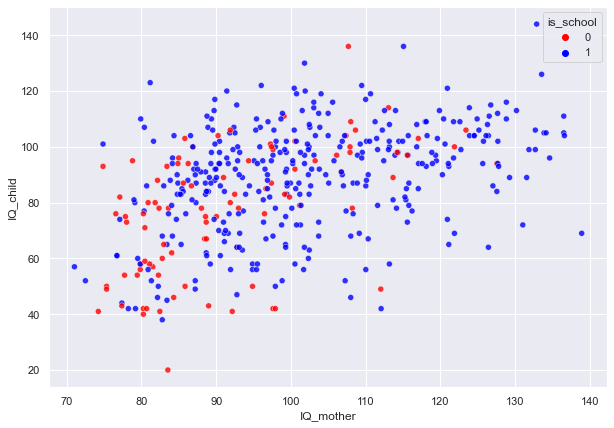

In [122]:
sns.set(style='darkgrid')
plt.figure(figsize=(10, 7))
sns.scatterplot(x='IQ_mother', y='IQ_child',
                data=data_new,
                hue='is_school',
                palette=['red','blue'],
                alpha=0.8)
plt.show()

Overall, there is a linear relationship between 'IQ_mother' and 'IQ_child'. Generally, 'IQ_child' increases as 'IQ_mother' increases. 

Besides, there are two groups in the plot. The red group of points has 'is_school' to be 0, while the blue group of points has 'is_school' to be 1. Within each group, 'IQ_mother' and 'IQ_child' also has a positive linear relationship. However, the linear regression coefficients can be different between these two groups. 

## 2.3 Boxplot of categorical variables

To understand how categorical variables affect the response variable, make a boxplot against 'IQ_child'.

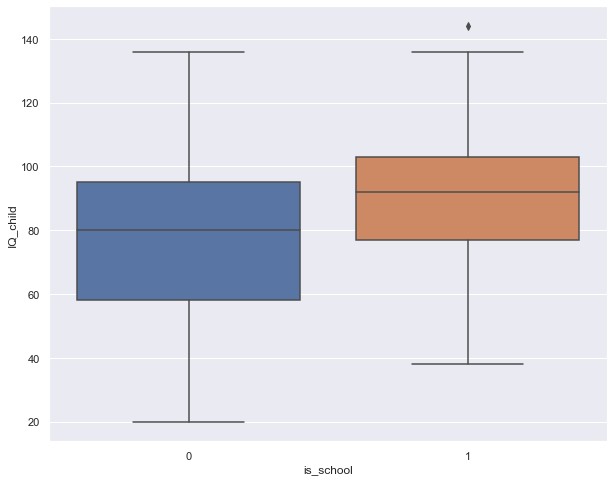

In [134]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='is_school', y='IQ_child',
            data=data_new)
plt.show()

Generally speaking, mother who has completed high school has child's IQ to be higher. Median, lower quartile and higher quartile of the complete-high-school mothers are all no smaller than that of the noncomplete-high-school mothers.

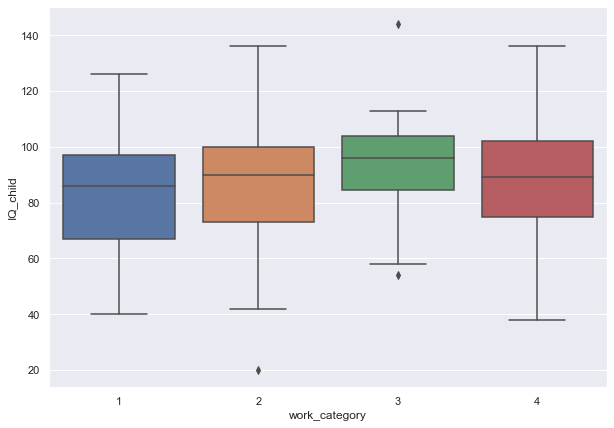

In [135]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='work_category', y='IQ_child',
            data=data_new)
plt.show()

Among all the categories, category 3, which is mother worked part-time in first year of child’s life, has the highest median. Other three categories have similar distributions. We can make the assumption that mothers who worked part-time in first year of child’s life have the child's IQ to be higher.

## 2.4 Scatterplot of age_birth & IQ_child

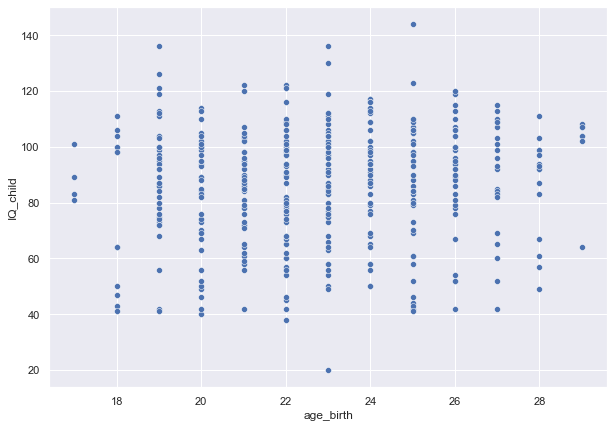

In [136]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='age_birth', y='IQ_child',
                data=data_new
               )
plt.show()

There is no obvious pattern in this scatterplot, which indicates 'age_birth' might not be an informative predictor for 'IQ_child'.

# 3 Regression Model

## 3.1 Simple linear regression

For the simple linear regression, choose the predictor to be 'IQ_mother'. From EDA in part 2, we see there is a linear relationship between the response variable and 'IQ_mother'. 


### 3.1.1 Build Model

Before fitting the model, split the dataset into training set and testing set by random split. Fit the model on the training set and evaluate the model on the testing set.

In [137]:
# split the dataset
data_train, data_test = train_test_split(data_new, test_size = 0.2, random_state = 42)

In [128]:
model1 = smf.ols("IQ_child ~ IQ_mother", data=data_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               IQ_child   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     79.34
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           3.05e-17
Time:                        18:47:10   Log-Likelihood:                -1500.2
No. Observations:                 347   AIC:                             3004.
Df Residuals:                     345   BIC:                             3012.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.4857      6.687      4.260      0.0

The intercept and the coefficient of IQ_mother are both significant (p-value close to 0). 

If mother's IQ increases by 1, the average child's IQ increases by 0.5883.

### 3.1.2 Model Evaluation

In terms of model evaluation, five metrics are chosen: 

(1) Adjusted R Square of the model fitted on training set

(2) Mean absolute error on the training set

(3) Mean absolute error on the training set

(4) Mean absolute error on the testing set

(5) Mean absolute error on the testing set

In [144]:
y_train_pred = model1.predict(data_train['IQ_mother'])
y_train = data_train['IQ_child']
y_test_pred = model1.predict(data_test['IQ_mother'])
y_test = data_test['IQ_child']


mae_train = mean_absolute_error(y_true=y_train,y_pred=y_train_pred)
mse_train = mean_squared_error(y_true=y_train,y_pred=y_train_pred)
mae_test = mean_absolute_error(y_true=y_test,y_pred=y_test_pred)
mse_test = mean_squared_error(y_true=y_test,y_pred=y_test_pred)

df_result = pd.DataFrame({'Adjusted_R2': [model1.rsquared_adj], 
                          'MAE_train': [mae_train], 
                          'MSE_train': [mse_train],
                          'MAE_test': [mae_test], 
                          'MSE_test': [mse_test]
                         })
df_result

,Adjusted_R2,MAE_train,MSE_train,MAE_test,MSE_test
0,0.184625,14.393855,333.191005,14.454253,329.675283


Adjusted R-square of the fitted model is 18.46%. About 18% of the variability observed in child's IQ is explained by mother's IQ.

### 3.1.3 Model Diagnosis

There are several assumptions for the single linear regression model:

(1) Linearity: The relationship between X and Y is linear.

(2) Normality: Residuals are normally distributed.

(3) Homoscedasticity: The variance of residual is the same for any value of X.

(4) Independence: Observations are independent of each other.

In [76]:
res = model1.resid

### (a) Normality Assumption 

Use histogram and qqplot to investigate the normality of residuals. qqplot compares the quantiles of the residual distribution to quantiles of a normal distribution.

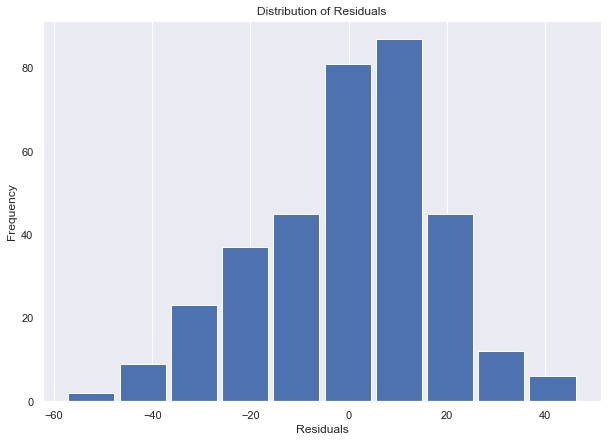

In [77]:
# check residual normality
# histogram of residual
plt.figure(figsize=(10, 7))
plt.hist(x=res, rwidth=0.9)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The distribution of the residuals is similar to a normal distribution.

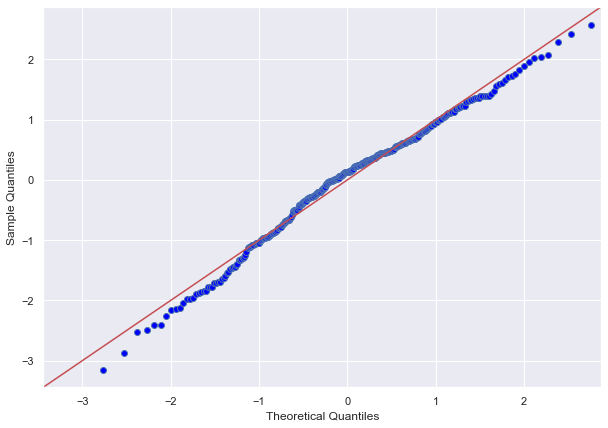

In [55]:
# qqplot
plt.rc("figure", figsize=(10,7))
sm.qqplot(res, line="45", fit=True)
plt.show()

Here residuals are first standardized. The quantiles of standardized residual distribution roughly equal the quantiles of a normal distribution except for some slight mismatches in the tail and the center. 



After the normality check plots, we can further investigate the normality by normality tests like Shapiro-Wilk test.

In [56]:
shapiro_test = stats.shapiro(res)
shapiro_test.pvalue

0.0025510196574032307

Shapiro test rejects the normal distribution (p-value < 0.05). 

Combined with the results from the above two plots, the residuals slightly violate the assumption of normality. However, it is not fatal when sample size is large. CLT will guarantee the inferential results.

### (b) Linearity and Homoscedasticity Assumption

The plot of residuals versus fitted values is useful for checking the assumption of linearity and homoscedasticity.

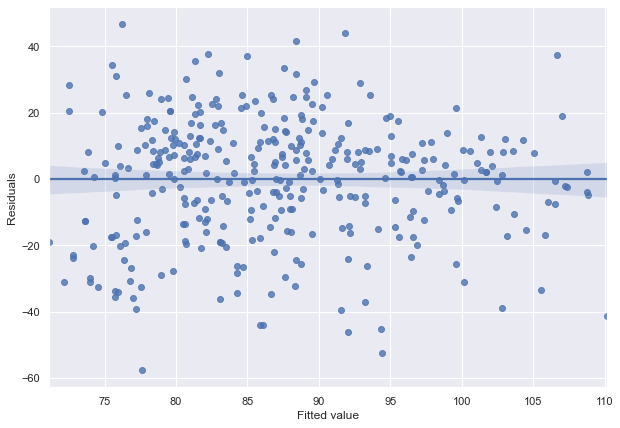

In [78]:
# heteroscedasticity check
plt.figure(figsize=(10, 7))
sns.regplot(x = y_train_pred, y = res, data = None, scatter = True)
plt.xlabel('Fitted value')
plt.ylabel('Residuals')
plt.show()

The residuals spread evenly around the 0 line. This suggests that the linearity assumption and the homoscedasticity assumption are reasonable. 

## 3.2 Multiple Linear Regresion 

In this part, build a linear regression with all the predictors. Note that 'is_school' and 'work_category' are treated as categorical variables. 'IQ_mother' and 'age_birth' are continuous variables.

### 3.2.1 Build Model

In [200]:
model2 = smf.ols("IQ_child ~ IQ_mother + age_birth + C(is_school) + C(work_category)", data=data_train).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               IQ_child   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     15.31
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           1.52e-15
Time:                        11:57:22   Log-Likelihood:                -1494.6
No. Observations:                 347   AIC:                             3003.
Df Residuals:                     340   BIC:                             3030.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                25.37

The intercept and the coefficients of 'IQ_mother', 'is_school' are significant (p-value < 0.05), which matches our assumption in Exploratory Data Analysis. 

If mother's IQ increases by 1 while other factors remain the same, the average child's IQ increases by 0.5223.

The average IQ of children with a completed-high-school mother is 7.4498 higher than the average IQ of children with a non-completed-high-school mother while other factors remain the same. 

### 3.2.2 Model Evaluation

Use the same evaluation metrics as the first part: 

(1) Adjusted R Square of the model fitted on training set

(2) Mean absolute error on the training set

(3) Mean absolute error on the training set

(4) Mean absolute error on the testing set

(5) Mean absolute error on the testing set

In [201]:
y_train_pred = model2.predict(data_train[['IQ_mother', 'age_birth', 'is_school', 'work_category']])
y_train = data_train['IQ_child']
y_test_pred = model2.predict(data_test[['IQ_mother', 'age_birth', 'is_school', 'work_category']])
y_test = data_test['IQ_child']


mae_train = mean_absolute_error(y_true=y_train,y_pred=y_train_pred)
mse_train = mean_squared_error(y_true=y_train,y_pred=y_train_pred)
mae_test = mean_absolute_error(y_true=y_test,y_pred=y_test_pred)
mse_test = mean_squared_error(y_true=y_test,y_pred=y_test_pred)

df_result2 = pd.DataFrame({'Adjusted_R2': [model2.rsquared_adj], 
                          'MAE_train': [mae_train], 
                          'MSE_train': [mse_train],
                          'MAE_test': [mae_test], 
                          'MSE_test': [mse_test]
                         })
df_result2

,Adjusted_R2,MAE_train,MSE_train,MAE_test,MSE_test
0,0.198864,14.169984,322.62814,14.865473,337.292031


Adjusted R-square of the fitted model is 19.88%. About 19% of the variability observed in child's IQ is explained by mother's IQ, whether mother completed high school, mother's age at child's birth, and mother's working status in child's early life.

### 3.2.3 Model Diagnosis

In multiple linear regression, there is one more assumption than the simple linear regression: non-multicollinearity.

(1) Linearity: The relationship between X and Y is linear.

(2) Normality: Residuals are normally distributed.

(3) Homoscedasticity: The variance of residual is the same for any value of X.

(4) Independence: Observations are independent of each other.

(5) Non-multicollinearity: There is no high correlation between two or more predictors.

In [202]:
res = model2.resid

### (a) Normality Assumption 

Use histogram and qqplot to investigate the normality of residuals. qqplot compares the quantiles of the residual distribution to quantiles of a normal distribution.

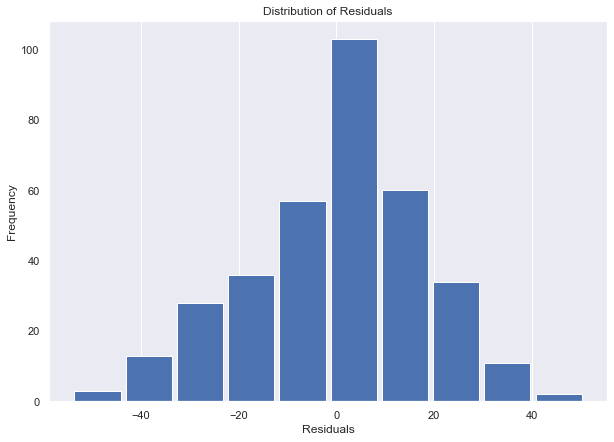

In [203]:
# check residual normality
# histogram of residual
plt.figure(figsize=(10, 7))
plt.hist(x=res, rwidth=0.9)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The distribution of the residuals is similar to a normal distribution.

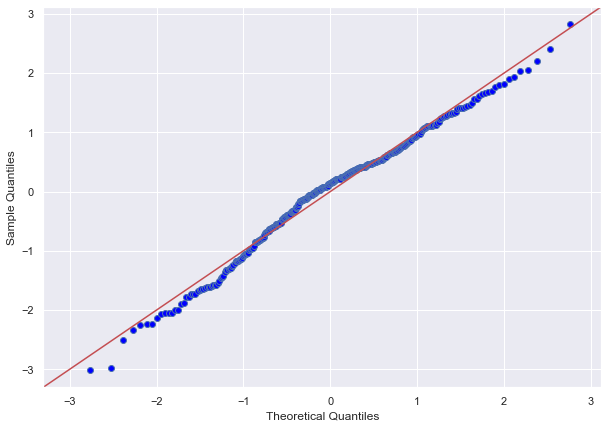

In [83]:
# qqplot
plt.rc("figure", figsize=(10,7))
sm.qqplot(res, line="45", fit=True)
plt.show()

Here residuals are first standardized. The quantiles of standardized residual distribution roughly equal the quantiles of a normal distribution except for some slight mismatches in the tail and the center.

After the normality check plots, we can further investigate the normality by normality tests like Shapiro-Wilk test.

In [204]:
shapiro_test = stats.shapiro(res)
shapiro_test.pvalue

0.0023826812393963337

Shapiro test rejects the normal distribution (p-value < 0.05). 

Combined with the results from the above two plots, the residuals slightly violate the assumption of normality. However, it is not fatal when sample size is large. CLT will guarantee the inferential results.

### (b) Linearity and Homoscedasticity Assumption

The plot of residuals versus predicted values is useful for checking the assumption of linearity and homoscedasticity.

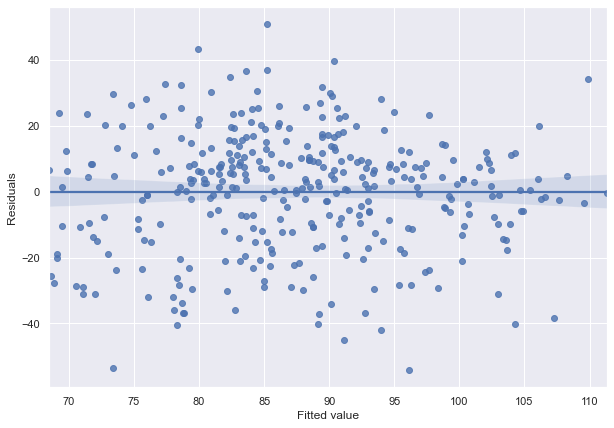

In [85]:
# heteroscedasticity check
plt.figure(figsize=(10, 7))
sns.regplot(x = y_train_pred, y = res, data = None, scatter = True)
plt.xlabel('Fitted value')
plt.ylabel('Residuals')
plt.show()

The residuals spread evenly around the 0 line. This suggests that the linearity assumption and the homoscedasticity assumption are reasonable. 

### (c) Multicollinearity & Collinearity Assumption

For collinearity, we can directly calculate the correlation of each pair of variables. For multicollinearity, since two or more variables are involved, VIF is a better approach.

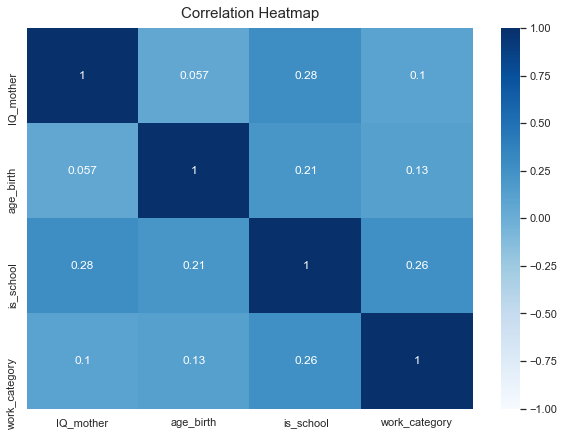

In [205]:
# Non-collinearity
predictors = data_train[['IQ_mother', 'age_birth', 'is_school', 'work_category']]
predictors = predictors.astype({'is_school':'int', 
                                'work_category': 'int'})
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(predictors.corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=10);

The correlation between each pair of variables approximately range from 0.05 to 0.3, which is not large, indicating the predictors do not have collinearity. 

In [209]:
# Non-multicollinearity
vif_df = pd.DataFrame()

predictors = data_train[['IQ_mother', 'age_birth', 'is_school', 'work_category']]
predictors = predictors.astype({'is_school':'int', 
                                'work_category': 'int'})
predictors = sm.add_constant(predictors)
vif_df["feature"] = ['IQ_mother', 'age_birth', 'is_school', 'work_category']
vif_df["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(1,len(vif_df)+1)]
print(vif_df)

         feature       VIF
0      IQ_mother  1.084785
1      age_birth  1.054187
2      is_school  1.191272
3  work_category  1.082337


VIF of predictors are all close to 1, which is a good sign that the predictors do not have multicollinearity problem either.

### 3.3 Multiple Linear Regresion with an interaction term

From the grouped scatterplot in EDA, we see that 'IQ_mother' can have a different effect on 'IQ_child' if 'is_school' has different values. Therefore, based on the previous model with all predictors, add in an interaction term: 'IQ_mother\*is_school'. 

### 3.3.1 Build Model

In [210]:
model3 = smf.ols("IQ_child ~ IQ_mother + age_birth + C(is_school) + C(work_category) + C(is_school)*IQ_mother", data=data_train).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:               IQ_child   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     14.53
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           1.49e-16
Time:                        12:00:41   Log-Likelihood:                -1490.6
No. Observations:                 347   AIC:                             2997.
Df Residuals:                     339   BIC:                             3028.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

The coefficients of 'IQ_mother', 'is_school', 'IQ_mother\*is_school' are significant (p-value < 0.05), which matches our assumption in Exploratory Data Analysis. 

When 'is_school' = 1 (mother completed high school), if mother's IQ increases by 1 while other factors remain the same, the average child's IQ increases by 0.9550-0.5178 = 0.4372.

When 'is_school' = 0 (mother didn't complete high school), if mother's IQ increases by 1 while other factors remain the same, the average child's IQ increases by 0.9550.

Predictor 'is_school' also has a different effect towards response varibale 'IQ_child' when 'IQ_mother' has different values. When 'is_school' changes from 1 to 0 (a mother who completed high school VS a mother who didn't complete high school), the average child's IQ decreases by 55.9460-0.5178\*IQ_mother.

### 3.3.2 Model Evaluation

Use the same evaluation metrics as the first part: 

(1) Adjusted R Square of the model fitted on training set

(2) Mean absolute error on the training set

(3) Mean absolute error on the training set

(4) Mean absolute error on the testing set

(5) Mean absolute error on the testing set

In [211]:
y_train_pred = model3.predict(data_train[['IQ_mother', 'age_birth', 'is_school', 'work_category']])
y_train = data_train['IQ_child']
y_test_pred = model3.predict(data_test[['IQ_mother', 'age_birth', 'is_school', 'work_category']])
y_test = data_test['IQ_child']


mae_train = mean_absolute_error(y_true=y_train,y_pred=y_train_pred)
mse_train = mean_squared_error(y_true=y_train,y_pred=y_train_pred)
mae_test = mean_absolute_error(y_true=y_test,y_pred=y_test_pred)
mse_test = mean_squared_error(y_true=y_test,y_pred=y_test_pred)

df_result3 = pd.DataFrame({'Adjusted_R2': [model3.rsquared_adj], 
                          'MAE_train': [mae_train], 
                          'MSE_train': [mse_train],
                          'MAE_test': [mae_test], 
                          'MSE_test': [mse_test]
                         })
df_result3

,Adjusted_R2,MAE_train,MSE_train,MAE_test,MSE_test
0,0.214954,13.861896,315.218727,14.775044,332.726315


Adjusted R-square of the fitted model is 21.49%. About 21% of the variability observed in child's IQ is explained by mother's IQ, whether mother completed high school, mother's age at child's birth, and mother's working status in child's early life and the interaction effect between mother's IQ and whether mother completed high school.

### 3.3.3 Model Diagnosis

Here the model assumptions are still the same as the multiple linear regression.

(1) Linearity: The relationship between X and Y is linear.

(2) Normality: Residuals are normally distributed.

(3) Homoscedasticity: The variance of residual is the same for any value of X.

(4) Independence: Observations are independent of each other.

(5) Non-multicollinearity: There is no high correlation between two or more predictors.

In [153]:
res = model3.resid

### (a) Normality Assumption 

Use histogram and qqplot to investigate the normality of residuals. qqplot compares the quantiles of the residual distribution to quantiles of a normal distribution.

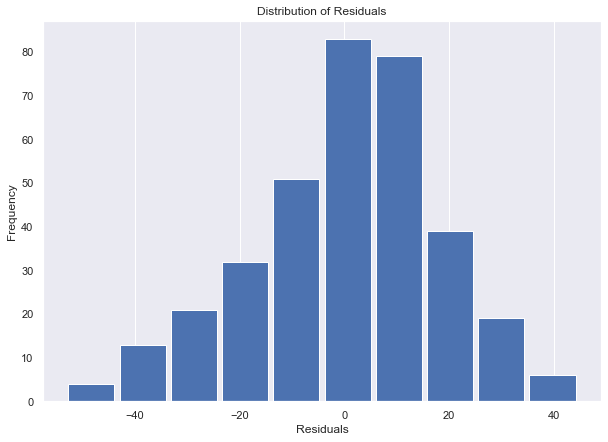

In [154]:
# check residual normality
# histogram of residual
plt.figure(figsize=(10, 7))
plt.hist(x=res, rwidth=0.9)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The distribution of the residuals is similar to a normal distribution.

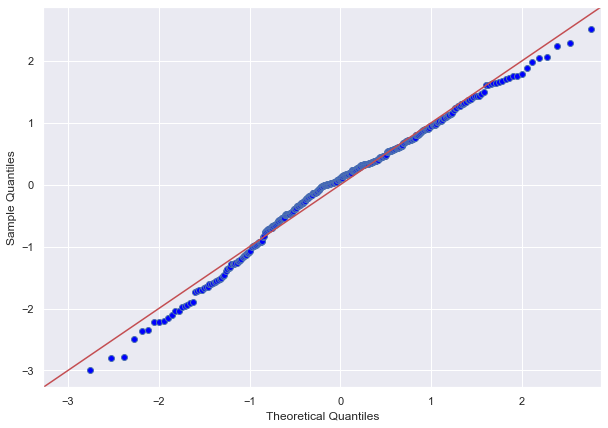

In [155]:
# qqplot
plt.rc("figure", figsize=(10,7))
sm.qqplot(res, line="45", fit=True)
plt.show()

Here residuals are first standardized. The quantiles of standardized residual distribution roughly equal the quantiles of a normal distribution except for some slight mismatches in the tail and the center.

After the normality check plots, we can further investigate the normality by normality tests like Shapiro-Wilk test.

In [156]:
shapiro_test = stats.shapiro(res)
shapiro_test.pvalue

0.0027881721034646034

Shapiro test rejects the normal distribution (p-value < 0.05). Combined with the results from the above two plots, the residuals slightly violate the assumption of normality. However, it is not fatal when sample size is large. CLT guarantees inferential results.

### (b) Linearity and Homoscedasticity Assumption

The plot of residuals versus fitted values is useful for checking the assumption of linearity and homoscedasticity.

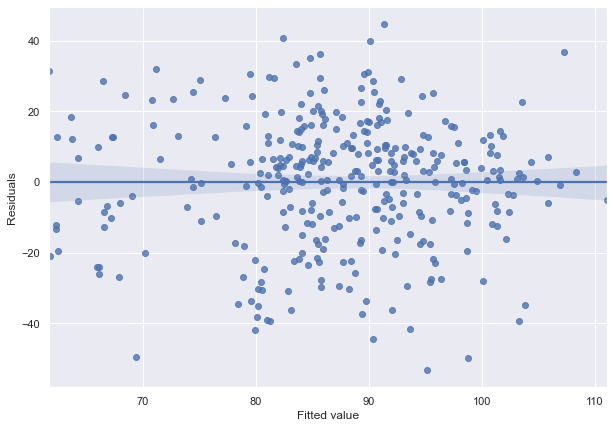

In [157]:
# heteroscedasticity check
plt.figure(figsize=(10, 7))
sns.regplot(x = y_train_pred, y = res, data = None, scatter = True)
plt.xlabel('Fitted value')
plt.ylabel('Residuals')
plt.show()

The residuals spread evenly around the 0 line. This suggests that the linearity assumption and the homoscedasticity assumption are reasonable. 

### (c) Multicollinearity & Collinearity Assumption

For collinearity, we can directly calculate the correlation of each pair of variables. For multicollinearity, since two or more variables are involved, VIF is a better metric.

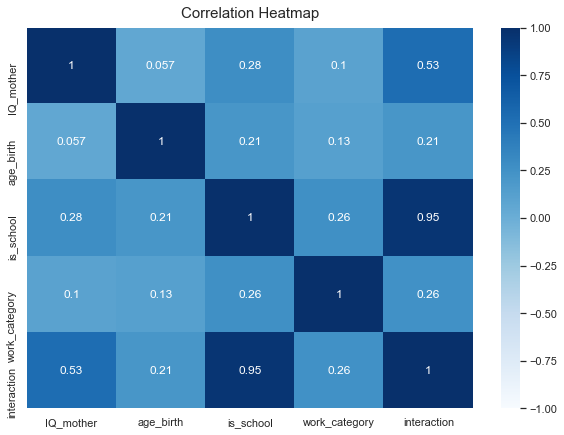

In [166]:
# Non-collinearity
predictors = data_train[['IQ_mother', 'age_birth', 'is_school', 'work_category']]
predictors = predictors.astype({'is_school':'int', 
                                'work_category': 'int'})
predictors['interaction'] = predictors['IQ_mother']*predictors['is_school']
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(predictors.corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=10);

The correlation between the interaction term 'IQ_mother\*is_school' and 'is_school' is 0.95, which is quite large. This is common where an interaction term is added, and it won't be fatal to the regression analysis.

In [169]:
# Non-multicollinearity
vif_df = pd.DataFrame()

predictors = data_train[['IQ_mother', 'age_birth', 'is_school', 'work_category']]
predictors = predictors.astype({'is_school':'int', 
                                'work_category': 'int'})
predictors['interaction'] = predictors['IQ_mother']*predictors['is_school']
predictors = sm.add_constant(predictors)
vif_df["feature"] = ['IQ_mother', 'age_birth', 'is_school', 'work_category', 'interaction']
vif_df["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(1,len(vif_df)+1)]
print(vif_df)

         feature        VIF
0      IQ_mother   6.638934
1      age_birth   1.065294
2      is_school  52.900065
3  work_category   1.083044
4    interaction  67.920805


Similarly, VIF of the interaction term 'IQ_mother\*is_school' and predictor 'is_school' are large after the interaction term is added. It is because they are highly correlated to each other. Multicollinearity and interaction term can be a trade-off in regression problems.

## 3.4 Model Summary

Compare the model performance in terms of five metrics in the model evaluation part.

In [194]:
df_all = pd.concat([df_result, df_result2, df_result3])
df_all.index= ['SLR', 'MLR', 'MLR_I']
df_all

,Adjusted_R2,MAE_train,MSE_train,MAE_test,MSE_test
SLR,0.184625,14.393855,333.191005,14.454253,329.675283
MLR,0.198864,14.169984,322.628140,14.865473,337.292031
MLR_I,0.214954,13.861896,315.218727,14.775044,332.726315


In [195]:
df_all['model'] = df_all.index

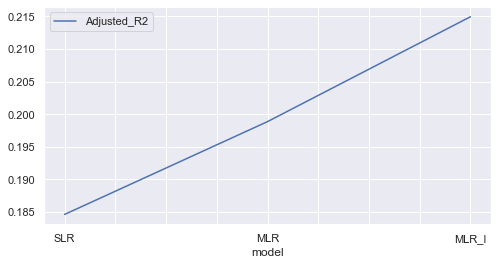

In [196]:
df_all.plot.line(x = 'model', y = 'Adjusted_R2', figsize = (8,4))
plt.show()

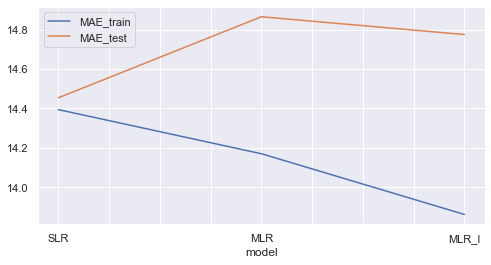

In [197]:
df_all.plot.line(x = 'model', y = ['MAE_train', 'MAE_test'], figsize = (8,4))
plt.show()

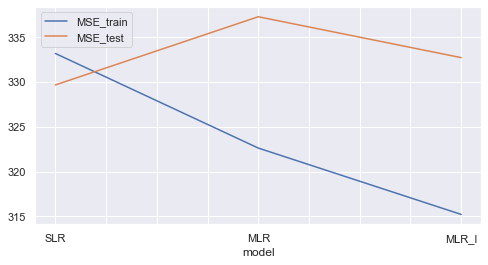

In [198]:
df_all.plot.line(x = 'model', y = ['MSE_train', 'MSE_test'], figsize = (8,4))
plt.show()

The adjusted R-square continues to increase as the model becomes complicated. The response varibale is better explained in the multiple linear regression model with an interaction term. Also, the mean-average-error and mean-sqaure-error continues to drop within the training set. 

However, there is no obvious trend of mean-average-error and mean-sqaure-error within the testing set. But we can tell that three models are not overfit by comparing MAE and MSE on training set and testing set.